# なりすまし検出への応用

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.chdir("..")
home_dir = os.getcwd()
os.chdir("src")
from accesstracer import AccessTracer
os.chdir(home_dir)
from IPython.display import display

## データの読み込み

In [2]:
df = pd.read_csv("data/masquerade-data/label", header=None)
df.columns = ["user_%s" % i for i in range(50)]
df.index = ["session_%s" % i for i in range(100)]
display(df.head())
print(df.shape)

,user_0,user_1,user_2,user_3,user_4,user_5,user_6,user_7,user_8,user_9,...,user_40,user_41,user_42,user_43,user_44,user_45,user_46,user_47,user_48,user_49
session_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
session_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
session_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
session_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
session_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(100, 50)


In [3]:
user30 = pd.read_csv("data/masquerade-data/User30", header=None)
user30.columns = ["command"]
display(user30.head())

,command
0,rdistd
1,tcsh
2,rshd
3,rdistd
4,tcsh


In [16]:
user30.command[8000:8300].unique()

array([ 0,  1,  2,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40])

In [5]:
# commandと置換後の数値の対応表
command_sheat = {command:num  for num, command in enumerate(user30.command.unique())}
print(command_sheat)

#commandを数値へ置換
user30 = user30.replace(command_sheat).copy()

display(user30.head())

{'rdistd': 0, 'tcsh': 1, 'rshd': 2, 'df': 3, 'touch': 4, 'cat': 5, 'file': 6, 'post': 7, 'awk': 8, 'rm': 9, 'generic': 10, 'ln': 11, 'lp': 12, 'sh': 13, 'getpgrp': 14, 'LOCK': 15, 'true': 16, 'ls': 17, 'sed': 18, 'FIFO': 19, 'date': 20, 'gethost': 21, 'download': 22, 'tcpostio': 23, 'UNLOCK': 24, 'rmdir': 25, 'tcppost': 26, 'netscape': 27, 'hostname': 28, 'id': 29, 'nawk': 30, 'getopt': 31, 'grep': 32, 'find': 33, 'expr': 34, 'sendmail': 35, 'MediaMai': 36, 'gs': 37, 'ghostvie': 38, 'launchef': 39, 'netstat': 40, 'mail': 41, 'more': 42, 'nslookup': 43, 'telnet': 44, 'ps': 45, 'su': 46, 'finger': 47, 'uname': 48}


,command
0,0
1,1
2,2
3,0
4,1


In [6]:
# 10コマンドからなる1500個のセッションを生成
window = 10
y = np.array([user30['command'][i:i+window].values for i in range(0, len(user30), window)])

display(y)
print(y.shape)

array([[0, 1, 2, ..., 1, 2, 0],
       [1, 2, 0, ..., 2, 0, 1],
       [2, 0, 1, ..., 0, 1, 2],
       ..., 
       [2, 0, 1, ..., 0, 1, 2],
       [0, 1, 2, ..., 1, 2, 0],
       [1, 2, 0, ..., 2, 0, 1]])

(1500, 10)


In [17]:
# Given
r = 0.01 # 忘却パラメータ 0<r<1
nu = 0.1 # 推定係数
K = 3 # 混合数
n = 1 # HMMの次数
M = y.shape[0] # データ数
Tj = y.shape[1] # セッションの長さ
N1 = 2 #?
N2 = len(command_sheat) #イベント数

In [18]:
ac = AccessTracer(r, nu, K, Tj, N1, N2, n=1)

In [19]:
ac.all_update(y)

In [20]:
df = pd.DataFrame(y, columns=["y%s" % i for i in range(1, Tj+1)])
df["N_K"] = ac.N_K
df["S_A"] = ac.S_A

display(df)

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,N_K,S_A
0,0,1,2,0,1,2,0,1,2,0,3.0,3.774688
1,1,2,0,1,2,0,1,2,0,1,3.0,3.486415
2,2,0,1,2,0,1,2,0,1,2,3.0,3.158764
3,0,1,2,0,1,2,0,1,2,0,1.0,2.792281
4,1,2,0,1,2,0,1,2,0,1,1.0,2.626375
5,2,0,1,2,0,1,2,0,1,2,1.0,2.525481
6,0,1,2,0,1,2,0,1,2,0,1.0,2.386499
7,1,2,0,1,2,0,1,2,0,1,1.0,2.290079
8,2,0,1,2,0,1,2,0,1,2,1.0,2.243627
9,0,1,2,0,1,2,0,1,2,0,1.0,2.144805


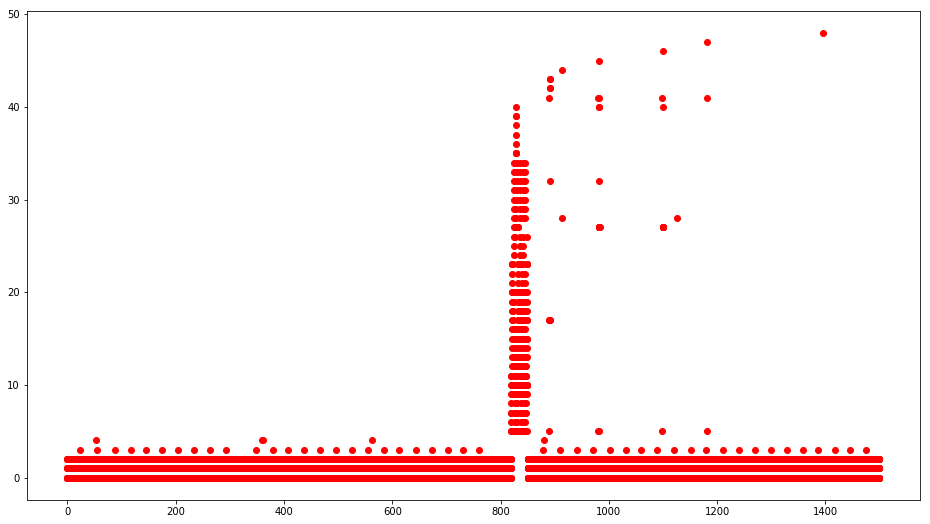

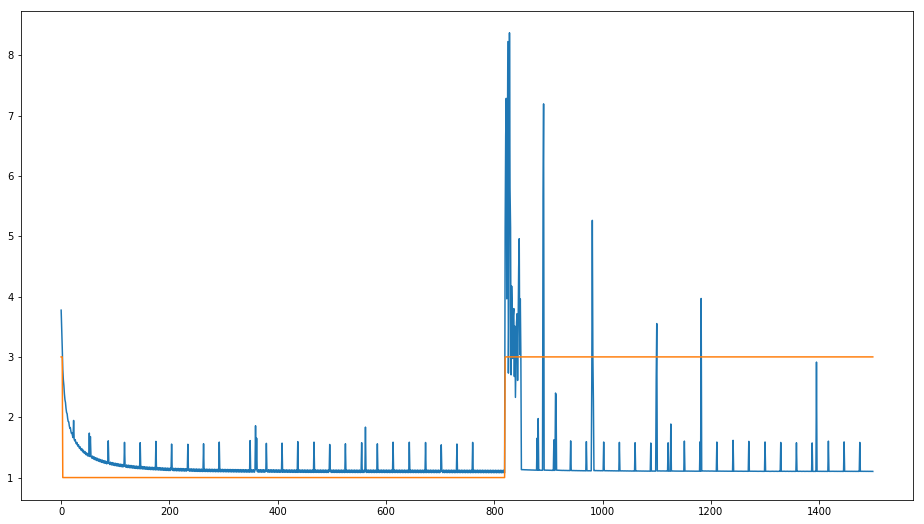

In [25]:
plt.figure(figsize=(16, 9))
plt.plot(y, "o", c="r")

plt.figure(figsize=(16, 9))
plt.plot(df.S_A)
plt.plot(df.N_K)